In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report, confusion_matrix

In [56]:
path_to_files = "stock_data/"
# path_to_sentiments1 = "stock_news_sentiment_scores/2011-2024/stock_news_sentiment_analysis_results_"
path_to_sentiments = "stock_news_sentiment_scores/2011-2024/stock_news_sentiment_analysis_results_"
path_to_global_news = "news_sentiment_scores/2000-2024/sentiment_analysis_results_"

stock_symbols = ['GOOG', 'MSFT', 'NVDA','AMZN','AAPL']

interval = 14 # Time interval for Standard Moving Average calculation 
start_date = pd.to_datetime('2012-01-01').date()
end_date = pd.to_datetime('2023-01-01').date()


In [57]:
def categorize_change(x):
    if pd.isnull(x):
        return None  # For the first day
    elif x > 0:
        return 1
    else:
        return 0
    
def classify_price_difference(row):
    if row['PD'] > 0.5:  # Significant rise
        return 2
    elif row['PD'] < -0.5:  # Significant fall
        return 0
    else:
        return 1  # No significant change
    
def balanced_weighted_average(sentiment_scores, decay_factor):
    """
    Calculate a balanced weighted average of sentiment scores without biasing towards negative values.
    
    Parameters:
    - sentiment_scores: A list or pandas Series of sentiment scores (positive and negative).
    - decay_factor: A value between 0 and 1 to control the decay rate of weights; defaults to 0.95.
    
    Returns:
    - A single balanced weighted average score.
    """
    # Initialize positive and negative scores with respective weights
    positive_scores = sentiment_scores[sentiment_scores > 0]
    negative_scores = sentiment_scores[sentiment_scores < 0]
    
    # Calculate decay weights for each score in reverse order (older scores get smaller weights)
    decay_weights = decay_factor ** np.arange(len(sentiment_scores))[::-1]

    # Separate weights for positive and negative scores
    pos_weights = decay_weights[:len(positive_scores)]
    neg_weights = decay_weights[:len(negative_scores)]

    # Calculate the weighted average for positive and negative scores separately
    pos_weighted_avg = (positive_scores * pos_weights).sum() / pos_weights.sum() if len(pos_weights) > 0 else 0
    neg_weighted_avg = (negative_scores * neg_weights).sum() / neg_weights.sum() if len(neg_weights) > 0 else 0

    # Return the balanced average by combining positive and negative averages equally
    balanced_avg = (pos_weighted_avg + neg_weighted_avg) / 2

    return balanced_avg    



def preprocess_and_merge_data(stock_symbols, start_date, end_date, interval):
    merged_data = {}
    X_features_ = None

    for symbol in stock_symbols:
        ## Load data
        df_sentiment = pd.read_csv(path_to_sentiments + symbol + ".csv")
        df_stock = pd.read_csv(path_to_files + symbol + "/stock_price.csv")
        df_news = pd.read_csv(path_to_global_news + symbol + ".csv") 

        ## Convert date columns
        df_sentiment['Date'] = pd.to_datetime(df_sentiment['Date'], utc=True).dt.date
        df_stock['Date'] = pd.to_datetime(df_stock['Date'], utc=True).dt.date
        df_news['Date'] = pd.to_datetime(df_news['Date'], utc=True).dt.date
        
        ## Rename columns
        rename_mapping1 = {
            'weighted positive sentiment score': 'Stock +ve Sentiment',
            'weighted negative sentiment score': 'Stock -ve Sentiment',
            'weighted neutral sentiment score': 'Stock Neutral',
            'weighted compound sentiment score': 'Stock Sentiment',
        }
        rename_mapping2 = {
            'weighted positive sentiment score': 'Global +ve Sentiment',
            'weighted negative sentiment score': 'Global -ve Sentiment',
            'weighted neutral sentiment score': 'Global Neutral',
            'weighted compound sentiment score': 'News Sentiment',
        }
        df_sentiment = df_sentiment.rename(columns=rename_mapping1)
        df_news = df_news.rename(columns=rename_mapping2)
        
        ## Evaluate Stock Features 
        df_stock['Log Return'] = np.log(df_stock['Close'] / df_stock['Close'].shift(1))
        df_stock['Volatility'] = df_stock['Log Return'].rolling(window=interval).std()
        df_stock['SMA'] = df_stock['Close'].rolling(window= interval).mean()
        df_stock['Difference'] = df_stock['Close'].diff()
        df_stock['PD'] = df_stock['Close'].pct_change().shift(-1)*100
        df_stock['Next Day Closing'] = df_stock['Close'].shift(-1)
        df_stock['RPM'] = df_stock['Close']/df_stock['SMA']
        df_stock['Trend'] = ((df_stock['Close'].shift(-1) > df_stock['Close']).astype(int)).shift(1).rolling(interval).sum()
        # Drop the first row where PD is NaN
        df_stock = df_stock.dropna(subset=['PD'])
        
        ## Filter by date range
        sentiment_filtered = df_sentiment[(df_sentiment['Date'] >= start_date) & (df_sentiment['Date'] <= end_date)]
        stock_filtered = df_stock[(df_stock['Date'] >= start_date) & (df_stock['Date'] <= end_date)]
        news_filtered = df_news[(df_news['Date'] >= start_date) & (df_news['Date'] <= end_date)]

        ## Remove 'Ticker' column
        sentiment_filtered = sentiment_filtered.drop(columns=['Ticker'])
        news_filtered = news_filtered.drop(columns=['Ticker'])
        
        ## Merge stock and sentiment data on common dates
        merged_df = pd.merge(stock_filtered, sentiment_filtered, on='Date', how='left')

        ## Merge news data, filling missing values with zeros
        merged_df = pd.merge(merged_df, news_filtered, on='Date', how='left')
        news_columns = news_filtered.columns.tolist()
        # news_columns.remove('Date')
        merged_df[news_columns] = merged_df[news_columns].fillna(0)

        X_features_ = merged_df.columns.tolist()
        merged_data[symbol] = merged_df.dropna()  # Drop NA after adding features
        
    return merged_data, X_features_


In [58]:
stock_data, Xfeatures = preprocess_and_merge_data(stock_symbols, start_date, end_date, interval)
stock_data['GOOG'].head(20)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Log Return,Volatility,...,RPM,Trend,Stock +ve Sentiment,Stock -ve Sentiment,Stock Neutral,Stock Sentiment,Global +ve Sentiment,Global -ve Sentiment,Global Neutral,News Sentiment
4,2012-01-09,16.062697,16.075122,15.434848,15.465409,233776981,0.0,0.0,-0.043324,0.016838,...,0.971045,8.0,0.058000,0.130000,0.812000,-0.575400,0.000,0.000000,0.000000,0.000000
11,2012-01-19,15.925799,15.925799,15.689019,15.890517,253157352,0.0,0.0,0.010468,0.016438,...,0.999521,10.0,0.159032,0.113639,0.783189,0.726337,0.000,0.000000,0.000000,0.000000
12,2012-01-20,14.672089,14.683766,14.452703,14.559290,424637703,0.0,0.0,-0.087493,0.028483,...,0.921589,9.0,0.065000,0.066000,0.869000,-0.025800,0.000,0.263000,0.737000,-0.446400
15,2012-01-25,14.348597,14.378412,14.072065,14.149336,200255805,0.0,0.0,-0.019889,0.026086,...,0.920844,6.0,0.186000,0.000000,0.814000,0.900900,0.000,0.187000,0.813000,-0.440400
34,2012-02-22,15.204531,15.324287,15.074091,15.104650,78974912,0.0,0.0,-0.009919,0.010234,...,1.003067,8.0,0.085000,0.047000,0.869000,0.442400,0.062,0.142000,0.796000,-0.401900
59,2012-03-28,16.200095,16.363082,16.176492,16.292768,101936657,0.0,0.0,0.013418,0.008952,...,1.039293,9.0,0.000000,0.057000,0.943000,-0.340000,0.000,0.000000,0.000000,0.000000
69,2012-04-12,15.959589,16.227672,15.907661,16.174751,231127086,0.0,0.0,0.023389,0.011287,...,1.014257,5.0,0.223000,0.046000,0.731000,0.738100,0.000,0.000000,0.000000,0.000000
70,2012-04-13,16.088786,16.124564,15.492242,15.518579,327595322,0.0,0.0,-0.041414,0.015906,...,0.975063,5.0,0.091000,0.046000,0.863000,0.340000,0.000,0.000000,0.000000,0.000000
77,2012-04-24,14.863649,15.072103,14.840790,14.938931,77453230,0.0,0.0,0.006123,0.016558,...,0.972697,5.0,0.165000,0.052000,0.783000,0.855500,0.109,0.148000,0.871936,-0.159900
83,2012-05-02,14.937191,15.108874,14.922532,15.087756,64701612,0.0,0.0,0.004671,0.015589,...,1.000354,6.0,0.116000,0.039000,0.845000,0.478600,0.000,0.000000,0.000000,0.000000


In [59]:
def train_predict(data, features, target, models_param_grid):
    results = {}

    for ticker, df in data.items():
        # Train-test split
        split_index = int(len(df) * 0.9)
        train_data = df.iloc[:split_index]
        test_data = df.iloc[split_index:]

        # Separate features (X) and target (y)
        X_train = train_data[features]
        y_train = train_data[target]
        X_test = test_data[features]
        y_test = test_data[target]

        # Initialize a results dictionary for this ticker
        results[ticker] = {}

        for model_name, (model, param_grid) in models_param_grid.items():
            print(f"Training {model_name} for {ticker}...")

            # Use TimeSeriesSplit for cross-validation
            tscv = TimeSeriesSplit(n_splits=5)

            # Perform GridSearchCV if param_grid is not empty
            if param_grid:
                search = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_mean_squared_error')
                search.fit(X_train, y_train)
                best_model = search.best_estimator_
                print(f"Best hyperparameters for {model_name}: {search.best_params_}")
            else:
                # If no hyperparameters to tune, fit the model directly
                best_model = model
                best_model.fit(X_train, y_train)

            # Predictions
            y_pred = best_model.predict(X_test)

            # Evaluation
            mse = mean_squared_error(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            print(f"{ticker} - Model: {model_name} - MSE: {mse:.4f}, MAE: {mae:.4f}")

            # Store Results
            results[ticker][model_name] = {
                'model': best_model,
                'mse': mse,
                'mae': mae,
                'y_test': y_test,
                'y_pred': y_pred
            }

    return results

In [60]:
# Define models and their parameter grids
models_param_grid = {
    'lr': (LinearRegression(), {}),
    'svr': (SVR(), {'kernel': ['rbf'], 'C': [1, 10], 'gamma': ['scale', 'auto']}),
    'knr': (KNeighborsRegressor(), {'n_neighbors': [5, 10, 15]}),
    'rf': (RandomForestRegressor(), {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}),
    'ab': (AdaBoostRegressor(), {'n_estimators': [50, 100], 'learning_rate': [0.1, 1.0]}),
    'gb': (GradientBoostingRegressor(), {'n_estimators': [100, 200], 'learning_rate': [0.1, 0.01]}),
    'xgb': (XGBRegressor(), {'n_estimators': [100, 200], 'learning_rate': [0.1, 0.01]})
}

Stock_Features = ['Volume', 'Open', 'Log Return', 'RPM', 'Trend', 'Volatility', 'Stock Sentiment', 'News Sentiment']  
Stock_Metrics = ['SMA', 'PD', 'Next Day Closing']


results = train_predict(stock_data, Stock_Features, target='SMA', models_param_grid = models_param_grid)

Training lr for GOOG...
GOOG - Model: lr - MSE: 1.4945, MAE: 0.8973
Training svr for GOOG...
Best hyperparameters for svr: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
GOOG - Model: svr - MSE: 333.6392, MAE: 14.7688
Training knr for GOOG...
Best hyperparameters for knr: {'n_neighbors': 10}
GOOG - Model: knr - MSE: 338.5935, MAE: 14.7405
Training rf for GOOG...
Best hyperparameters for rf: {'max_depth': 20, 'n_estimators': 100}
GOOG - Model: rf - MSE: 43.5772, MAE: 5.5707
Training ab for GOOG...
Best hyperparameters for ab: {'learning_rate': 0.1, 'n_estimators': 100}
GOOG - Model: ab - MSE: 88.3569, MAE: 7.8821
Training gb for GOOG...
Best hyperparameters for gb: {'learning_rate': 0.1, 'n_estimators': 200}
GOOG - Model: gb - MSE: 11.5155, MAE: 2.9161
Training xgb for GOOG...
Best hyperparameters for xgb: {'learning_rate': 0.1, 'n_estimators': 200}
GOOG - Model: xgb - MSE: 45.2907, MAE: 5.7220
Training lr for MSFT...
MSFT - Model: lr - MSE: 10.0404, MAE: 2.4168
Training svr for MSFT...
B

In [61]:
def collect_metrics(results):
    metrics_data = []
    for ticker, models_results in results.items():
        for model_name, metrics in models_results.items():
            metrics_data.append({
                'Ticker': ticker,
                'Model': model_name,
                'MSE': metrics['mse'],
                'MAE': metrics['mae']
            })
    metrics_df = pd.DataFrame(metrics_data)
    return metrics_df

metrics_df = collect_metrics(results)

model_order = ['lr', 'svr', 'knr', 'rf', 'ab', 'gb', 'xgb']
metrics_df['Model'] = pd.Categorical(metrics_df['Model'], categories=model_order, ordered=True)

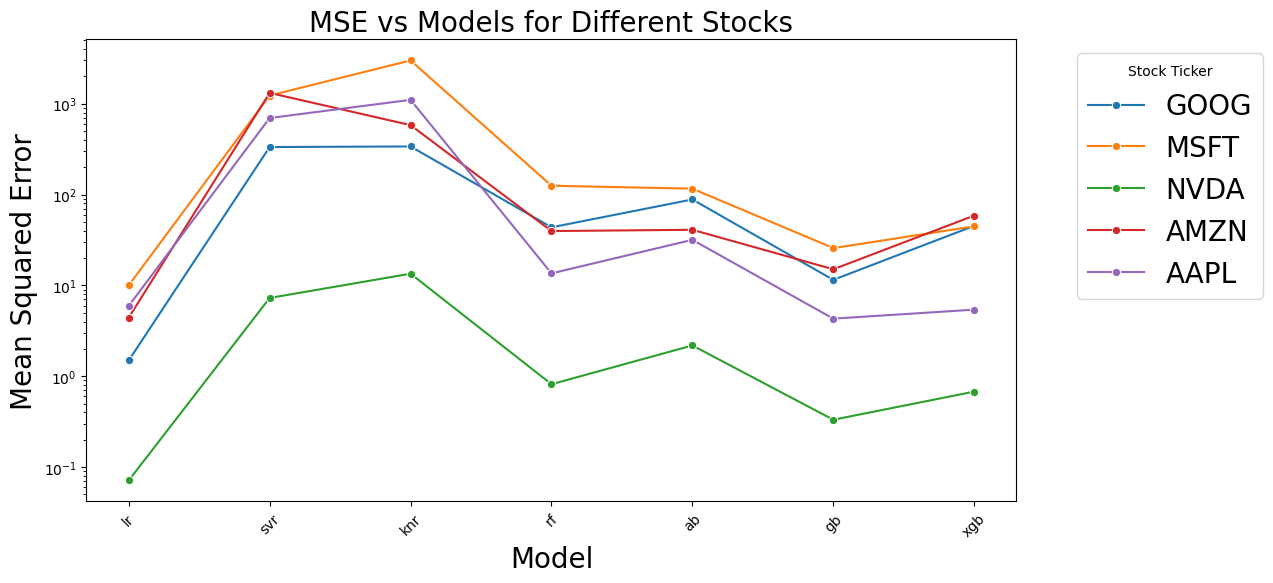

In [62]:
plt.figure(figsize=(12, 6))

# sns.barplot(data=metrics_df, x='Model', y='MSE', hue='Ticker')
sns.lineplot(data=metrics_df, x='Model', y='MSE', hue='Ticker', marker='o')

plt.title('MSE vs Models for Different Stocks', fontsize = 20)
plt.ylabel('Mean Squared Error', fontsize = 20)
plt.xlabel('Model', fontsize = 20)
plt.legend(title='Stock Ticker', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize = 20)
plt.yscale('log')
plt.xticks(rotation=45)
# plt.tight_layout()
plt.show()

In [63]:
res1 = train_predict(stock_data, Stock_Features, target='PD', models_param_grid = models_param_grid)

Training lr for GOOG...
GOOG - Model: lr - MSE: 6.7157, MAE: 1.9588
Training svr for GOOG...
Best hyperparameters for svr: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
GOOG - Model: svr - MSE: 6.5091, MAE: 1.8927
Training knr for GOOG...
Best hyperparameters for knr: {'n_neighbors': 15}
GOOG - Model: knr - MSE: 6.7459, MAE: 1.9055
Training rf for GOOG...
Best hyperparameters for rf: {'max_depth': 10, 'n_estimators': 200}
GOOG - Model: rf - MSE: 7.1344, MAE: 1.9495
Training ab for GOOG...
Best hyperparameters for ab: {'learning_rate': 0.1, 'n_estimators': 50}
GOOG - Model: ab - MSE: 6.5769, MAE: 1.9094
Training gb for GOOG...
Best hyperparameters for gb: {'learning_rate': 0.01, 'n_estimators': 100}
GOOG - Model: gb - MSE: 6.6077, MAE: 1.8854
Training xgb for GOOG...
Best hyperparameters for xgb: {'learning_rate': 0.01, 'n_estimators': 100}
GOOG - Model: xgb - MSE: 6.5682, MAE: 1.8760
Training lr for MSFT...
MSFT - Model: lr - MSE: 5.4133, MAE: 1.7278
Training svr for MSFT...
Best hyperpa

In [ ]:
metrics_PD = collect_metrics(res1)

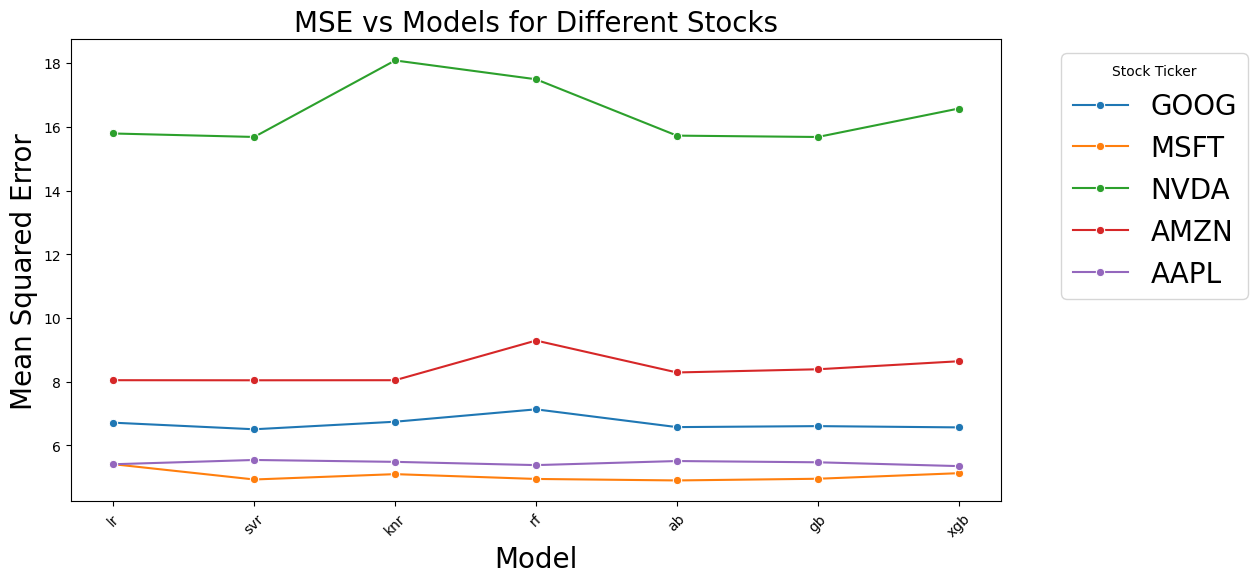

In [65]:
plt.figure(figsize=(12, 6))

# sns.barplot(data=metrics_df, x='Model', y='MSE', hue='Ticker')
sns.lineplot(data=metrics_PD, x='Model', y='MSE', hue='Ticker', marker='o')

plt.title('MSE vs Models for Different Stocks', fontsize = 20)
plt.ylabel('Mean Squared Error', fontsize = 20)
plt.xlabel('Model', fontsize = 20)
plt.legend(title='Stock Ticker', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize = 20)
# plt.yscale('log')
plt.xticks(rotation=45)
# plt.tight_layout()
plt.show()